## Домашнее задание №4. Классификатор отзывов к фильмам
В рамках домашнего задания разработаем систему классификации отзывов к фильмам на положительные и отрицательные. Такая система может быть полезна, например, компаниям, которые анализируют отзывы в социальных сетях, и решают, стоит ли снимать продолжение к фильму.

Это задача на работу с естественным языком. Несмотря на то, что применяемые техники довольно простые, они позволят проиллюстрировать как задачу классификации, так и несколько основных идей из области анализа текстов. 

### Feature engineering
Как мы уже успели рассмотреть на занятиях, методы машинного обучения обычно работают с признаковым представлением объекта, задачу выделения признаков неформально называют feature engineering. Выделить признаки, на которых можно обучать модели, не всегда легко, выделение хороших признаков зачастую оказывается более сложной задачей, чем построение модели машинного обучения.

В рамках домашнего задания рассмотрим, как можно выделить признаки из текстовой информации, чтобы построить классификатор текстов. Более подробно тему feature engineering рассмотрим в следующем модуле. 

### Модель «Мешок Слов»

Одной из простейших идей при работе с текстами является модель «мешка слов» (bag of the words, bow). Идея заключается в том, что порядок слов для тематики не важен, а важны только сами слова. 

Частота встречающихся слов в этом подходе будет тем самым признаком, который мы можем использовать для обучения классификатора. Это не совсем точно, ведь фразы «мне не понравился фильм» и »не мне понравился фильм» отличаются только порядком слов, но имеют разный смысл. Тем не менее, как показывает практика, такого подхода достаточно, чтобы определить тональность или тематику текста.


Определим функцию преобразования текста в «мешок слов», слово будем определять как последовательность русских букв. Будем искать их при помощи регулярных выражений (про регулярные выражения можно почитать тут: https://habr.com/post/349860/). Весь текст будем приводить к нижнему регистру, чтобы слова, написанные в разных регистрах, не отличались друг от друга. 

In [1]:
import re

def text2bow(text):
    result = dict()
    word_regexp = re.compile(r'[а-я]+')
    for word in word_regexp.findall(text.lower()):
        if word not in result:
            result[word] = 1
        else:
            result[word] = result[word] + 1
    return result
            
print(text2bow('Мне не понравился фильм, а ему понравился фильм'))

{'мне': 1, 'не': 1, 'понравился': 2, 'фильм': 2, 'а': 1, 'ему': 1}


Мы возвращаем словарь с частотами слов. Для того, чтобы работать с моделями машинного обучения, нам нужно «табличное» представление даннных. Это можно сделать при помощи pandas, так как в нем уже реализовано преобразование словарей в DataFrame:

In [3]:
import pandas as pd
docs = [
            text2bow('Мне не понравился фильм, а ему понравился фильм. Каково черта'), 
            text2bow('Фильм был очень хороший! Мне понравился'), 
       ]
df = pd.DataFrame(docs)
df

,а,был,ему,каково,мне,не,очень,понравился,фильм,хороший,черта
0,1.0,NaN,1.0,1.0,1,1.0,NaN,2,2,NaN,1.0
1,NaN,1.0,NaN,NaN,1,NaN,1.0,1,1,1.0,NaN


Пустоты лучше заполнить нулями:

In [4]:
df = df.fillna(0.0)
df

,а,был,ему,каково,мне,не,очень,понравился,фильм,хороший,черта
0,1.0,0.0,1.0,1.0,1,1.0,0.0,2,2,0.0,1.0
1,0.0,1.0,0.0,0.0,1,0.0,1.0,1,1,1.0,0.0


Мы преобразовали тексты в таблицу, теперь к ним можно применять модели машинного обучения. Давайте загрузим настоящие данные — отзывы к фильмам. Мы заранее привели их к модели «мешок слов».

В выборке 30 000 примеров, мы отфильтровали 10 000 самых популярных слов на русском языке, чтобы данных не получилось слишком много. Колонка is_positive содержит целевую функцию (положительный отзыв или отрицательный).

Внимание! Данных довольно много, их загрузка займет продолжительное время.

In [15]:
data = pd.read_csv('train.csv', dtype='uint8')
data.head()

,is_positive,а,абсолютная,абсолютно,абсолютное,абсолютной,абсурд,абсурда,аварии,австралии,...,ярко,яркого,яркое,яркой,яркую,ярости,ярость,ярче,ясно,ящик
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
labels = data['is_positive']
del(data['is_positive'])

# Задание №1 

Разделите выборку на тестовую и контрольную при помощи функции train_test split. Не забудьте импортировать функцию train_test_split из модуля sklearn.metrics. Пример можно посмотреть в предыдущем домашнем задании или в видео про разделение выборки на train и test.

In [17]:
#подставьте нужные вызовы вместо слов в угловых скобках
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data,labels)

# Задание №2

##### Обязательная часть
Обучите модель классификации. Необходимо импортировать модель машинного обучения из библиотеки Sklear, обучить ее и проверить на тестовых данных. Вы можете попробовать разные модели. Мы рекомендуем следущие:

- DecisionTreeClassifier из модуля sklearn.tree
- RandomForestClassifier из модуля sklearn.ensemble

Для получения зачета нужно получить значение метрики AUC не менее 0.7
##### Необязательная часть 1
Для получения зачета вам достаточно построить одну из моделей с параметрами по умолчанию, но, чтобы улучшить свой результат, вы можете задать параметры моделей. У модели RandomForestClassfier для улучшения качества можно задавать, например, такие параметры: 
- Количество деревьев(n_estimators)
- Максимальную высоту дерева(max_depth)

Полный список критериев можно посмотреть в оффициальной документации:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

##### Необязательная часть 2
Вы можете самостоятельно найти другие модели классификации для достижения еще лучшего качества модели. Можете поискать, например, как построить логистическую регрессию или градиентный бустинг.

In [55]:
# подставьте нужные значения модуля и модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [19]:


# подставьте значения для создания модели
model = DecisionTreeClassifier()
model.fit(train_data, train_labels)
prediction = model.predict_proba(test_data)[:,1]

auc = roc_auc_score(test_labels, prediction)
print("auc:", auc)

auc: 0.6149727682484036


In [50]:
# подставьте значения для создания модели
model_rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

model_rf.fit(train_data, train_labels)
prediction_rf = model_rf.predict_proba(test_data)[:,1]

auc_rf = roc_auc_score(test_labels, prediction_rf)
print("auc rf:", auc_rf)

auc rf: 0.9184013083761113


In [58]:
# подставьте значения для создания модели
model_et = ExtraTreesClassifier(n_estimators=200,criterion='gini',max_depth=30,
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None,
                                random_state=None, verbose=0, warm_start=False, class_weight=None)

model_et.fit(train_data, train_labels)
prediction_et = model_et.predict_proba(test_data)[:,1]

auc_et = roc_auc_score(test_labels, prediction_et)
print("auc et:", auc_et)

auc et: 0.8525859208714162


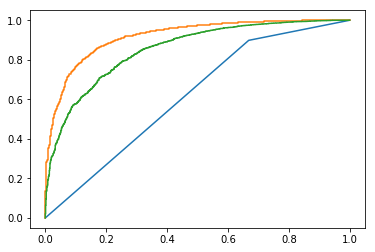

In [59]:
prediction_probe = model.predict_proba(test_data)[:,1]
prediction_probe_rf = model_rf.predict_proba(test_data)[:,1]
prediction_probe_et = model_et.predict_proba(test_data)[:,1]

fpr_dt,tpr_dt, threshold_dt = roc_curve(test_labels,prediction_probe)
fpr_rf,tpr_rf, threshold_rf = roc_curve(test_labels,prediction_probe_rf)
fpr_et,tpr_et, threshold_et = roc_curve(test_labels,prediction_probe_et)

plt.plot(fpr_dt,tpr_dt)
plt.plot(fpr_rf,tpr_rf)
plt.plot(fpr_et,tpr_et)

### Оценивание задания.

Выполните предсказания для контрольных данных, скопируйте и вставьте результат в систему в EdX на странице «Домашнее задание».

Критерии оценки:
    - AUC меньше 0.7 — незачет
    - AUC от 0.7 до 0.8 — 0.8 балла
    - AUC от 0.8 до 0.9 — 0.9 балла
    - AUC больше 0.9 — 0.9 

In [54]:
data_control = pd.read_csv('control.csv')
prediction = model_rf.predict_proba(data_control)[:,1]
print(','.join("{:.3f}".format(p) for p in prediction))

0.804,0.735,0.833,0.922,0.865,0.823,0.857,0.604,0.824,0.776,0.738,0.846,0.651,0.949,0.808,0.890,0.803,0.835,0.704,0.878,0.786,0.808,0.873,0.937,0.867,0.820,0.750,0.772,0.780,0.845,0.927,0.917,0.808,0.892,0.806,0.899,0.828,0.908,0.771,0.834,0.895,0.817,0.894,0.864,0.856,0.745,0.817,0.633,0.902,0.721,0.784,0.884,0.907,0.892,0.887,0.896,0.751,0.866,0.777,0.806,0.862,0.658,0.803,0.868,0.928,0.844,0.887,0.809,0.893,0.848,0.845,0.874,0.872,0.878,0.831,0.872,0.786,0.911,0.798,0.786,0.900,0.648,0.913,0.926,0.838,0.809,0.888,0.712,0.819,0.859,0.897,0.925,0.923,0.926,0.928,0.941,0.891,0.868,0.783,0.890,0.928,0.833,0.917,0.797,0.891,0.830,0.731,0.821,0.840,0.863,0.904,0.802,0.905,0.777,0.832,0.810,0.839,0.621,0.873,0.886,0.935,0.849,0.886,0.919,0.666,0.636,0.731,0.897,0.809,0.762,0.845,0.873,0.956,0.737,0.640,0.847,0.921,0.888,0.692,0.793,0.884,0.710,0.812,0.879,0.895,0.858,0.833,0.741,0.841,0.800,0.884,0.772,0.858,0.927,0.882,0.764,0.858,0.823,0.915,0.813,0.616,0.708,0.874,0.864,0.832,0.892,0.62

Выполните строчку выше, скопируйте и вставьте результат в систему в EdX.

# Дополнительная информация

Вам интересно посмотреть, как ваша модель классифицирует реальные отзывы? Ниже приведен код, при помощи которого это можно сделать. Мы преобразуем отзыв в «мешок слов» и подаем на вход модели. Отличие от того, что мы делали ранее, — в модели зафиксирован порядок признаков, поэтому мы передаем дополнительный параметр columns.

In [165]:
review = "Лучший фильм, который я когда-либо видел!"


bows = [text2bow(review)]
data_my = pd.DataFrame(bows, columns=train_data.columns).fillna(0.0)
score = model.predict_proba(data_my)[:,1][0]
print("Результат автоматической классификации: {:.3f}".format(score))

Результат автоматической классификации: 0.965


Модель мешка слов, которую мы с вами использовали, является простой. Более сложные модели используют порядок слов, а также приводят слова к нормальному виду. Продвинутые современные методы базируются на рекуррентных и сверточных нейросетях. Смотрите: https://habr.com/company/dca/blog/274027/